In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Barcode-variant table
--

In [2]:
df = pd.read_csv("results/variants/codon_variant_table.csv")
# Note: an explicit display() is need to avoid SettingWithCopyWarning bug later
display(df)

,target,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,CGG_naive,lib1,AAAAAAAAAACACCGG,6,GGC119GGT TTA200ACT,L200T,2,1
1,CGG_naive,lib1,AAAAAAAAAACATGAG,1,CAG16TGG,Q16W,1,1
2,CGG_naive,lib1,AAAAAAAAAAGCGACG,1,GTG156CAT,V156H,1,1
3,CGG_naive,lib1,AAAAAAAAAAGGAAAG,6,GTG110GGT,V110G,1,1
4,CGG_naive,lib1,AAAAAAAAAATATAGA,1,TAC47CCA,Y47P,1,1
...,...,...,...,...,...,...,...,...
192424,CGG_naive,lib2,TTTTTTCTAAACAAGT,3,AGG181ACT,R181T,1,1
192425,CGG_naive,lib2,TTTTTTGACCCCCCCA,12,GCT178ACT TCC179ACT,A178T S179T,2,2
192426,CGG_naive,lib2,TTTTTTGCTGTGTATC,5,NaN,NaN,0,0
192427,CGG_naive,lib2,TTTTTTGGTGAAAGTT,4,GCT152ATT,A152I,1,1


Site $\times$ site heatmap of the number of variants that have each site pair mutated, and historgram over site pairs

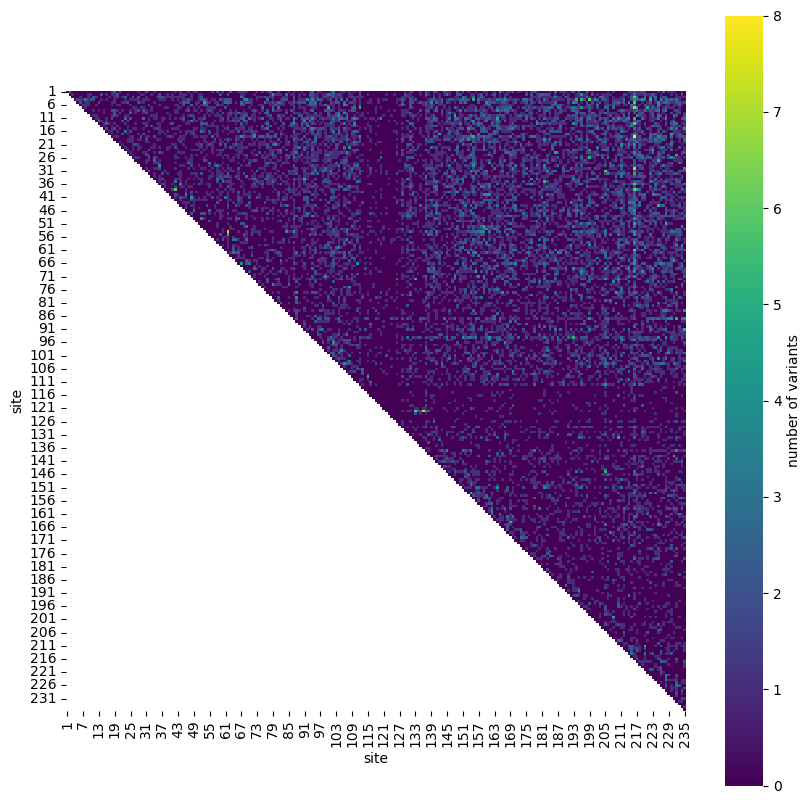

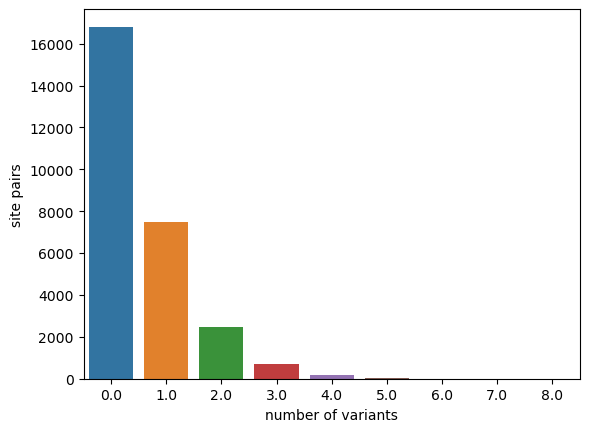

In [3]:
positions = range(1, int(pd.read_csv("data/CGGnaive_sites.csv").site_scFv.max()) + 1)
sitepair_counts_df = pd.DataFrame(index=positions, columns=positions, dtype=int)
sitepair_counts_df.values[np.triu_indices(sitepair_counts_df.shape[0])] = 0

for mutations in df.groupby("aa_substitutions").aa_substitutions.first().str.split():
    if len(mutations) < 2:
        continue
    sites = [int(mutation[1:-1])for mutation in mutations]
    for i, site1 in enumerate(sites[:-1]):
        for site2 in sites[i + 1:]:
            sitepair_counts_df.loc[site1, site2] += 1

plt.figure(figsize=(10, 10))
sns.heatmap(data=sitepair_counts_df, vmin=0, square=True, cmap='viridis', cbar_kws={'label': 'number of variants'})
plt.xlabel('site')
plt.ylabel('site')
plt.show()

plt.figure()
sns.countplot(x=sitepair_counts_df.values.ravel())
plt.xlabel('number of variants')
plt.ylabel('site pairs')
plt.show()

Barcode counts for each site $\times$ amino acid single mutant variant

In [4]:
df = df.loc[(df.n_aa_substitutions == 1)]
df["position"] = df.loc[:, "aa_substitutions"].str[1:-1].astype(int)
df["AA"] = df.loc[:, "aa_substitutions"].str[-1]

df = df.loc[(df.n_aa_substitutions == 1) & (df.library == "lib1")].groupby(["position", "AA"]).size().rename("barcode count").reset_index()
df

,position,AA,barcode count
0,1,A,8
1,1,C,9
2,1,D,8
3,1,F,11
4,1,G,15
...,...,...,...
4218,235,S,25
4219,235,T,20
4220,235,V,14
4221,235,W,17


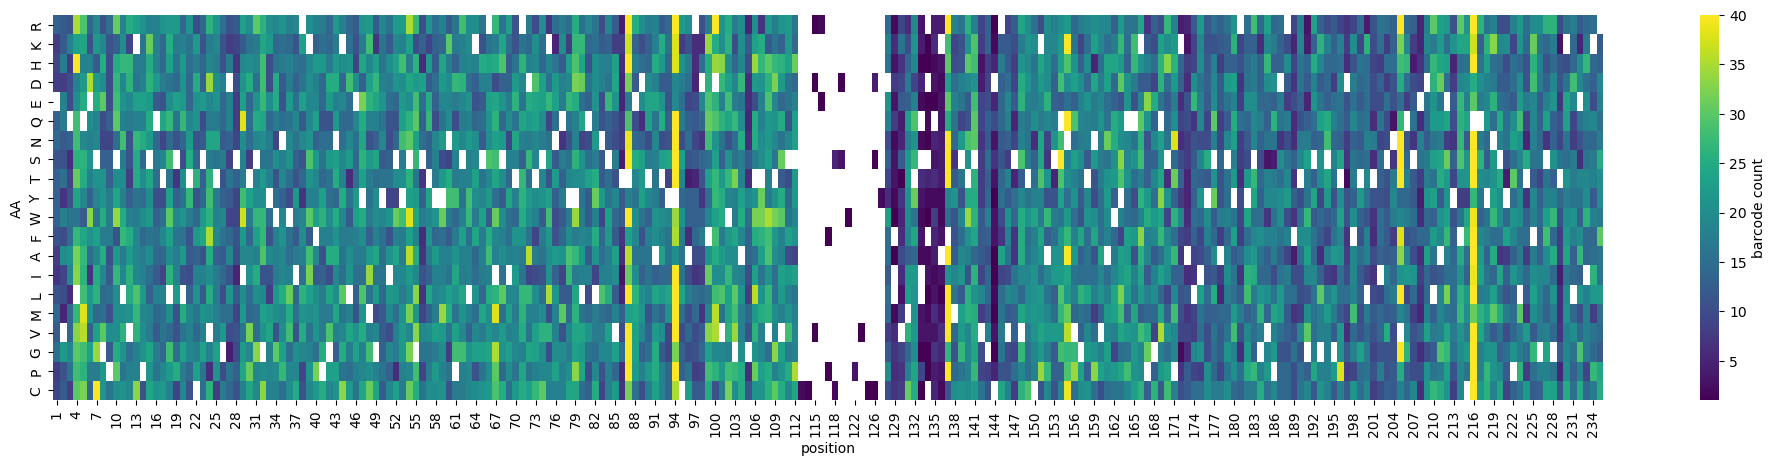

In [5]:
heatmap_df = df.pivot(index="AA", columns="position", values="barcode count")
heatmap_df = heatmap_df.loc[["C","P","G","V","M","L","I","A","F","W","Y","T","S","N","Q","E","D","H","K","R"]]

plt.figure(figsize=(25, 5))
ax = sns.heatmap(heatmap_df, cmap="viridis", vmax=40, cbar_kws={'label': 'barcode count'})
ax.invert_yaxis()
plt.show()

Affinity data
--

In [6]:
df = pd.read_csv("results/binding_Kd/bc_binding.csv")
df = df.loc[~df.log10Ka.isna()]
df

,library,barcode,target,variant_class,aa_substitutions,n_aa_substitutions,TiteSeq_avgcount,log10Ka
0,lib1,AAAAAAAAAACACCGG,CGG_naive,1 nonsynonymous,L200T,1,26.923275,8.846567
1,lib1,AAAAAAAAAACATGAG,CGG_naive,1 nonsynonymous,Q16W,1,18.782567,9.970348
3,lib1,AAAAAAAAAAGGAAAG,CGG_naive,1 nonsynonymous,V110G,1,24.172350,10.226335
5,lib1,AAAAAAAAAATTCCTA,CGG_naive,1 nonsynonymous,V12F,1,29.063494,10.703464
6,lib1,AAAAAAAAAATTGCCA,CGG_naive,>1 nonsynonymous,S28R T199G,2,29.290444,10.373170
...,...,...,...,...,...,...,...,...
192422,lib2,TTTTTTAGAAGCGAAG,CGG_naive,wildtype,NaN,0,151.565250,10.488299
192425,lib2,TTTTTTGACCCCCCCA,CGG_naive,>1 nonsynonymous,A178T S179T,2,123.106203,10.640967
192426,lib2,TTTTTTGCTGTGTATC,CGG_naive,wildtype,NaN,0,54.904519,10.513270
192427,lib2,TTTTTTGGTGAAAGTT,CGG_naive,1 nonsynonymous,A152I,1,17.261457,10.685635


Some summary plot of barcode info for affinity data

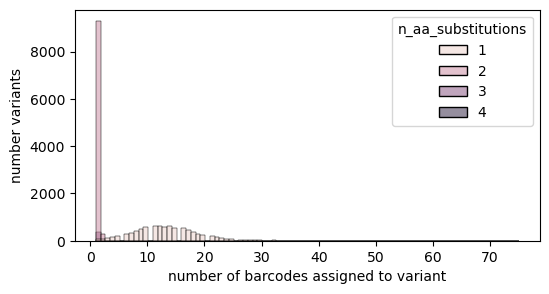

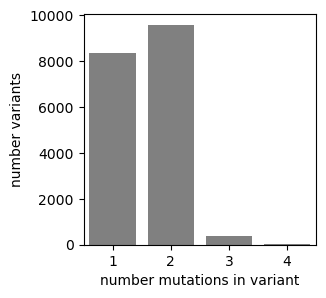

In [7]:
from scipy.stats import poisson

# group by variants (set of mutations)
groups = df.groupby(["aa_substitutions", "library"])

n_barcodes = groups.size()
n_mutations = groups.first().n_aa_substitutions
mean_affinity = groups.mean().log10Ka

plt.figure(figsize=(6, 3))
sns.histplot(x=n_barcodes, hue=n_mutations)
plt.xlabel("number of barcodes assigned to variant")
plt.ylabel("number variants")
# sns.histplot(x=n_barcodes, hue=n_mutations, stat="proportion", common_norm=False, multiple="dodge")
plt.show()

plt.figure(figsize=(3, 3))
sns.countplot(x=n_mutations, color="grey")
plt.xlabel("number mutations in variant")
plt.ylabel("number variants")
plt.show()

Use variants with a several barcodes to assess heteroskedasticity

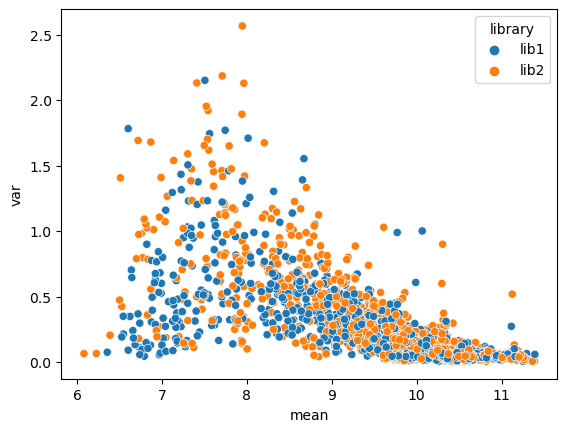

In [8]:
skedacity_dat = groups.agg(['mean', 'var', 'size']).log10Ka.reset_index()

size_thresh = 10
plt.figure()
sns.scatterplot(data=skedacity_dat.loc[skedacity_dat["size"] >= size_thresh], x="mean", y="var", hue="library", color='red', legend=True)
plt.show()

Shrinkage estimation of variance of the mean phenotype over barcodes
--

For each variant, we would like to estimate the variance of the mean phenotype over barcodes. To estimate population means per variant, we extend the empirical Bayes variance shrinkage estimator of [Lu and Stephens](http://stephenslab.uchicago.edu/assets/papers/lu-stephens-2016.pdf). We allow the mode of the inverse gamma variance prior to be a function of the variant-wise population mean phenotype, and this heteroskedasticity function is represented as a spline. For estimating of the heteroskedacticity function, we use the sample means to approximate the population means.

Notation below as in Lu and Stephens.

We first define the likelihood and fit it to the data. 

In [9]:
from scipy.special import gammaln
from scipy.stats import invgamma
from scipy.optimize import minimize
from scipy.interpolate import PchipInterpolator, interp1d
from numpy.polynomial import Polynomial

def logL(a, c, s, n):
    b = (a + 1) * c
    d = n - 1

    s = s[d > 0]
    b = b[d > 0]
    d = d[d > 0]

    if any(d < 1):
        print("a")
    if any(s <= 0):
        print("b")
    if any(b <= 0):
        print("c")
    
    return np.sum((d / 2) * np.log(d / 2) + (d - 1 / 2) * np.log(s) + gammaln(a + d / 2) + a * np.log(b) - gammaln(d / 2) - gammaln(a) - (a + d / 2) * np.log(d * s ** 2 / 2 + b))

variants = [key[0] for key, group in groups]
b_bar = np.array([group.log10Ka.mean() for key, group in groups])
s = np.array([group.log10Ka.std(ddof=0) for key, group in groups])
n = np.array([group.shape[0] for key, group in groups])

loga = 0
coefs = np.zeros(5)

# note: different size threshold for fitting
fit_size_thresh = 20

knots = np.quantile(b_bar[n > fit_size_thresh], np.linspace(0, 1, len(coefs)))
def c_func_factory(knots, coefs):
#     return np.exp(Polynomial(coefs)(x))
    return interp1d(knots, np.exp(coefs), fill_value="extrapolate")

result = minimize(lambda x: -logL(np.exp(x[0]),
                                  c_func_factory(knots, x[1:])(b_bar[n >= fit_size_thresh]),
                                  s[n >= fit_size_thresh], n[n >= fit_size_thresh]),
                  (loga, *coefs),
                  tol=1e-20, options=dict(maxiter=1000), method="BFGS")
result

      fun: -66.48037900740981
 hess_inv: array([[ 1.88398207e-05, -4.54142505e-05,  5.85870348e-05,
         6.98433007e-05, -1.22941395e-04,  3.95501095e-05],
       [-4.54142505e-05,  1.80901779e-03, -6.09208323e-04,
         1.18438650e-04,  1.69634356e-04, -1.18087180e-04],
       [ 5.85870348e-05, -6.09208323e-04,  2.15710398e-03,
        -4.66535671e-04, -8.63885856e-06, -5.43852764e-04],
       [ 6.98433007e-05,  1.18438650e-04, -4.66535671e-04,
         1.22844291e-03, -2.46661485e-04, -2.39866646e-04],
       [-1.22941395e-04,  1.69634356e-04, -8.63885856e-06,
        -2.46661485e-04,  1.22866459e-03, -7.45448745e-04],
       [ 3.95501095e-05, -1.18087180e-04, -5.43852764e-04,
        -2.39866646e-04, -7.45448745e-04,  3.94886112e-03]])
      jac: array([ 1.97410583e-04,  4.57763672e-05,  1.14440918e-05,  8.58306885e-06,
       -4.67300415e-05, -9.53674316e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 830
      nit: 30
     njev: 1

### Plot the fitted prior

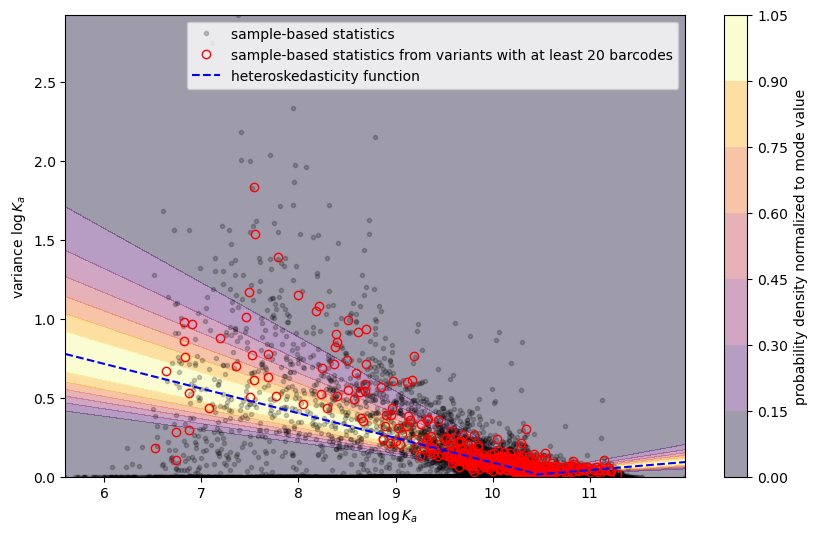

zooming in to wild type region


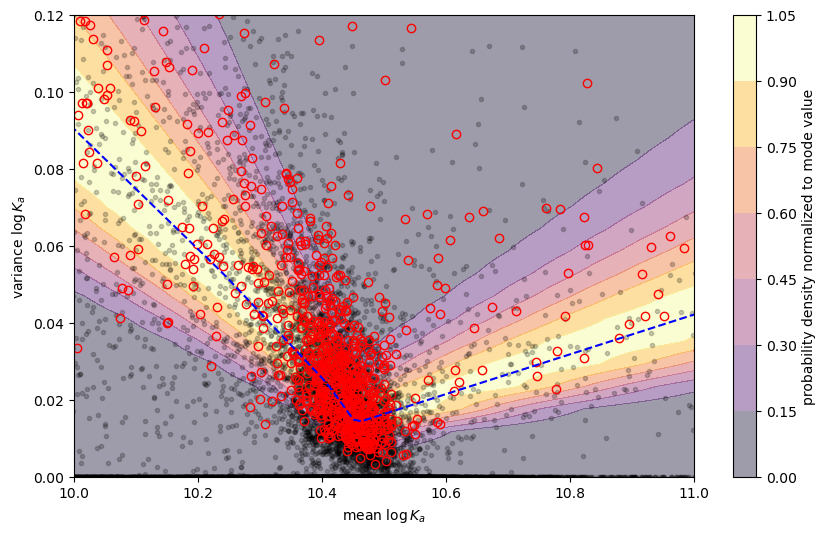

In [10]:
a = np.exp(result.x[0])
c_func = c_func_factory(knots, result.x[1:])

x = np.linspace(np.nanmin(b_bar), np.nanmax(b_bar), 500)

c = c_func(x[:, None])
b = (a + 1) * c

rv = invgamma(a, scale=b)

for foo in (1, 2):

    plt.figure(figsize=(10, 6))

    y = np.linspace(0, np.nanmax(s) ** 2, 500)
    z = rv.pdf(y) / rv.pdf(c)
    plt.contourf(x, y, z.T, vmin=0, vmax=1, cmap="inferno", alpha=0.4)
    plt.colorbar(label="probability density normalized to mode value")

    plt.plot(b_bar[n < fit_size_thresh], s[n < fit_size_thresh] ** 2, "k.", alpha=0.2,
             label=f"sample-based statistics")

    plt.plot(b_bar[n >= fit_size_thresh], s[n >= fit_size_thresh] ** 2, "o", color="r",
             markerfacecolor='none', markeredgewidth=1,
             label=f"sample-based statistics from variants with at least {fit_size_thresh} barcodes")

    plt.plot(x, c, "b--", label="heteroskedasticity function")

    plt.xlabel(r"mean $\log K_a$")
    plt.ylabel(r"variance $\log K_a$")

    if foo == 2:
        print("zooming in to wild type region")
        plt.xlim(10., 11)
        plt.ylim(0, 0.12)
    else:
        plt.legend()

#     plt.yscale("log")
        
    plt.show()

## A function for assigning the posterior expected precision, given sample precision and prior fit (see Lu and Stephens section 2.4)

In [11]:
# Lu and Stephens
def posterior_expected_precision(s, n, a, c):
    b = (a + 1) * c
    d = n - 1
    a_twiggle = a + d / 2
    b_twiggle = b + d * np.nan_to_num(s) ** 2 / 2
    return a_twiggle / b_twiggle

Compute and plot shrinkage estimates
--

In [31]:
df_shrink = pd.DataFrame({"$n$ barcodes": n, r"$\overline{\log K_a}$": b_bar, "sample variance": s ** 2, "shrinkage estimate": 1 / posterior_expected_precision(s, n, a, c_func(b_bar))},
                         index=pd.Series(variants, name="variant"))

df_shrink

,$n$ barcodes,$\overline{\log K_a}$,sample variance,shrinkage estimate
variant,,,,
A104C,18,5.328488,0.685945,0.798865
A104C,19,5.542382,1.284095,1.119398
A104C A173E,1,6.596114,0.000000,0.712944
A104C F137L,1,5.144860,0.000000,0.972772
A104C G105V,1,5.488061,0.000000,0.911327
...,...,...,...,...
Y94V V130D K151T,1,11.405820,0.000000,0.072378
Y94V Y218T,1,11.663206,0.000000,0.087626
Y94W,24,11.529232,0.120250,0.105170


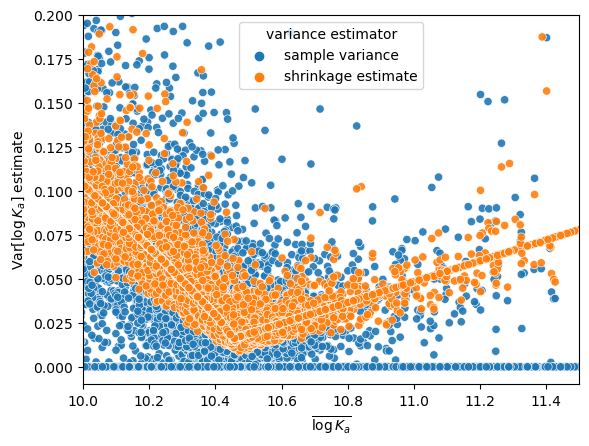

In [42]:
# df_shrink = df_shrink.melt(id_vars=r"$\overline{\log K_a}$", value_vars=("sample variance", "shrinkage estimate"), var_name="variance estimator", value_name=r"$\mathrm{Var}[\log K_a]$ estimate")

sns.scatterplot(data=df_shrink, x=r"$\overline{\log K_a}$", y=r"$\mathrm{Var}[\log K_a]$ estimate", hue="variance estimator", alpha=0.9)

plt.xlim(10, 11.5)
plt.ylim(-.01, 0.2)

plt.show()

Simulatation study, where true variances are known
--

### Generate simulated barcode data

In [14]:
y_hat = np.sort(b_bar)
c = c_func(y_hat)

from scipy.stats import poisson, norm
s_squared_true = invgamma(a, scale=(a + 1) * c).rvs()

b_sim = [norm(y_hat[i], scale=np.sqrt(s_squared_true[i])).rvs(n[i]) for i in range(len(n))]
b_bar = np.array([b_sim[i].mean() for i in range(len(n))])
s = np.array([np.nanstd(b_sim[i], ddof=0) for i in range(len(n))])

loga = 0
logc = 0

result_hom = minimize(lambda x: -logL(np.exp(x[0]),
                                   np.exp(x[1]) * np.ones_like(n),
                                  s, n),
                  (loga, logc),
                  tol=1e-20, options=dict(maxiter=1000), method="BFGS")

coefs = np.ones(5)
knots = np.quantile(y_hat, np.linspace(0, 1, len(coefs)))

result_het = minimize(lambda x: -logL(np.exp(x[0]),
                                  c_func_factory(knots, x[1:])(b_bar[n >= fit_size_thresh]),
                                  s[n >= fit_size_thresh], n[n >= fit_size_thresh]),
                  (result_hom.x[0], *(result_hom.x[1] * coefs)),
                  tol=1e-20, options=dict(maxiter=1000), method="BFGS")

### Assess inference of prior parameters

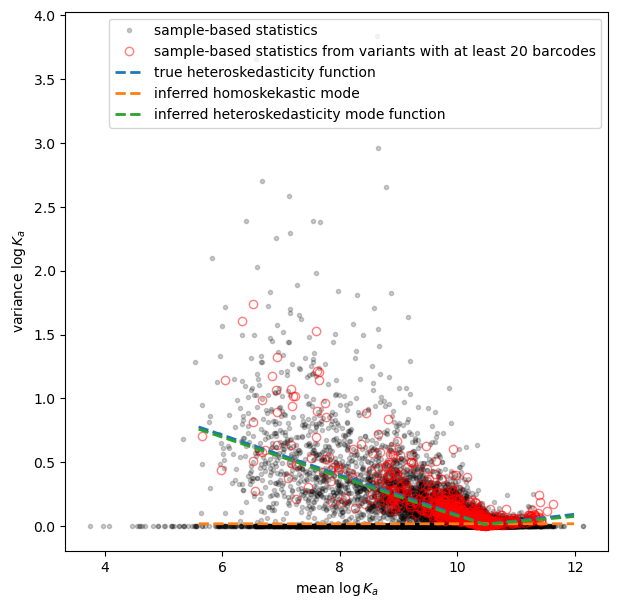

In [15]:
a_hom = np.exp(result_hom.x[0])
a_het = np.exp(result_het.x[0])
# note: this is where you would need tdms estimator, but what if we do hacky shit like use b_bar, teehee
c_hom = np.exp(result_hom.x[1]) * np.ones_like(b_bar)
c_het = c_func_factory(knots, result_het.x[1:])(b_bar)

plt.figure(figsize=(7, 7))

plt.plot(b_bar[n < fit_size_thresh], s[n < fit_size_thresh] ** 2, "k.", alpha=0.2,
         label=f"sample-based statistics")

plt.plot(b_bar[n >= fit_size_thresh], s[n >= fit_size_thresh] ** 2, "o", color="r", alpha=0.5,
         markerfacecolor='none', markeredgewidth=1,
         label=f"sample-based statistics from variants with at least {fit_size_thresh} barcodes")

plt.plot(y_hat, c, "--", lw=2, label="true heteroskedasticity function")
plt.plot(y_hat, c_hom, "--", lw=2, label="inferred homoskekastic mode")
plt.plot(y_hat, c_func_factory(knots, result_het.x[1:])(y_hat), "--", lw=2, label="inferred heteroskedasticity mode function")

plt.xlabel(r"mean $\log K_a$")
plt.ylabel(r"variance $\log K_a$")

plt.legend()
plt.show()

### Assess inference of true variances

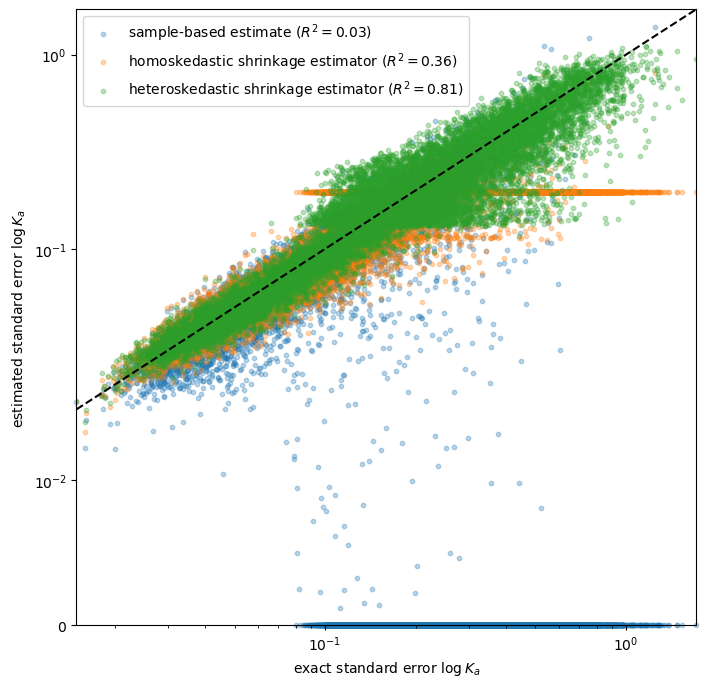

In [16]:
s_squared_het = 1 / posterior_expected_precision(s, n, a_het, c_het)
s_squared_hom = 1 / posterior_expected_precision(s, n, a_hom, c_hom)

from scipy.stats import pearsonr

plt.figure(figsize=(8, 8))

plt.scatter(np.sqrt(s_squared_true / n), s / np.sqrt(n), 10, alpha=0.3, clip_on=False, label=f"sample-based estimate ($R^2={pearsonr(np.sqrt(s_squared_true / n), s / np.sqrt(n))[0] ** 2:.2f})$")
plt.scatter(np.sqrt(s_squared_true / n), np.sqrt(s_squared_hom / n), 10, alpha=0.3, label=f"homoskedastic shrinkage estimator ($R^2={pearsonr(np.sqrt(s_squared_true / n), np.sqrt(s_squared_hom / n))[0] ** 2:.2f})$")
plt.scatter(np.sqrt(s_squared_true / n), np.sqrt(s_squared_het / n), 10, alpha=0.3, label=f"heteroskedastic shrinkage estimator ($R^2={pearsonr(np.sqrt(s_squared_true / n), np.sqrt(s_squared_het / n))[0] ** 2:.2f})$")

plt.xlabel(r"exact standard error $\log K_a$")
plt.ylabel(r"estimated standard error $\log K_a$")

plt.plot([np.sqrt(s_squared_true / n).min(), np.sqrt(s_squared_true / n).max()],
         [np.sqrt(s_squared_true / n).min(), np.sqrt(s_squared_true / n).max()], "k--")

plt.xlim(np.sqrt(s_squared_true / n).min(), np.sqrt(s_squared_true / n).max())
plt.ylim(0, np.sqrt(s_squared_true / n).max())

plt.xscale("log")
plt.yscale("symlog", linthresh=np.sqrt(s_squared_true / n).min())

plt.legend(loc="upper left")
plt.show()